In [39]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math
from statistics import mean
import pickle
import random
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import time
import timeit

In [40]:
useSyntheticData = True

#Nethealt = 4, synthetic = 5
n_types = 5
n_epoch = 15
seq_len = 750
batch_size = 10
hidden_size = 64
# RELU | SOFTPLUS | SOFTPLUS_SCALE
transform_fun = 'SOFTPLUS_SCALE'
# W2V = 2, GCN = 1
number_of_embedding_features = 1
number_of_spatio_features = 1
# p = 1 for GCN and W2V
windows_p = 3

use_data_from_files = True 

# NN | GCN | TGCN | W2V | TW2V
model = 'TGCN'

In [41]:
if(useSyntheticData):
  events_df = pd.read_csv('./social-interactions/events_syn.csv')
else:
  events_df = pd.read_csv('./social-interactions/events.csv')  
events_df

,epochtime,date,time,dayofweek,insession,studyweek,studyday,egoid,egoconf,alterid,alterconf,outgoing,iphone,eventtype,eventtypedetail,messagetype,duration,length,bytes
0,1420088400000,2015-01-01,00:00:00,Thursday,No,-33,-227,27169,0.95,2250922,0.6,No,1,SMS,iM,NaN,NaN,13.0,NaN
1,1420088401000,2015-01-01,00:00:01,Thursday,No,-33,-227,96184,0.95,738850,0.7,No,1,WhatsApp,DM,T,NaN,1.0,NaN
2,1420088403000,2015-01-01,00:00:03,Thursday,No,-33,-227,96184,0.95,738850,0.7,No,1,WhatsApp,DM,T,NaN,1.0,NaN
3,1420088405000,2015-01-01,00:00:05,Thursday,No,-33,-227,19538,0.95,270980,0.5,No,1,SMS,iM,NaN,NaN,12.0,NaN
4,1420088406000,2015-01-01,00:00:06,Thursday,No,-33,-227,96184,0.95,738850,0.7,No,1,WhatsApp,DM,T,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1423622182000,2015-02-10,21:36:22,Tuesday,No,-27,-187,96689,0.95,345868,0.3,Yes,1,SMS,iM,NaN,NaN,6.0,NaN
1048571,1423622184000,2015-02-10,21:36:24,Tuesday,No,-27,-187,57697,0.95,828541,0.5,No,1,SMS,iM,NaN,NaN,26.0,NaN
1048572,1423622185000,2015-02-10,21:36:25,Tuesday,No,-27,-187,57697,0.95,828541,0.5,No,1,SMS,iM,NaN,NaN,8.0,NaN
1048573,1423622186000,2015-02-10,21:36:26,Tuesday,No,-27,-187,29232,0.95,286474,0.7,Yes,1,SMS,SM,NaN,NaN,9.0,NaN


In [42]:
events_df = events_df.sort_values(by=['epochtime'], ascending=True).reset_index()

In [43]:
if('_id' not in events_df.columns):
  events_df['_id'] = events_df.index

In [44]:
events_df

,index,epochtime,date,time,dayofweek,insession,studyweek,studyday,egoid,egoconf,...,alterconf,outgoing,iphone,eventtype,eventtypedetail,messagetype,duration,length,bytes,_id
0,0,1420088400000,2015-01-01,00:00:00,Thursday,No,-33,-227,27169,0.95,...,0.6,No,1,SMS,iM,NaN,NaN,13.0,NaN,0
1,1,1420088401000,2015-01-01,00:00:01,Thursday,No,-33,-227,96184,0.95,...,0.7,No,1,WhatsApp,DM,T,NaN,1.0,NaN,1
2,2,1420088403000,2015-01-01,00:00:03,Thursday,No,-33,-227,96184,0.95,...,0.7,No,1,WhatsApp,DM,T,NaN,1.0,NaN,2
3,3,1420088405000,2015-01-01,00:00:05,Thursday,No,-33,-227,19538,0.95,...,0.5,No,1,SMS,iM,NaN,NaN,12.0,NaN,3
4,4,1420088406000,2015-01-01,00:00:06,Thursday,No,-33,-227,96184,0.95,...,0.7,No,1,WhatsApp,DM,T,NaN,2.0,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1048570,1423622182000,2015-02-10,21:36:22,Tuesday,No,-27,-187,96689,0.95,...,0.3,Yes,1,SMS,iM,NaN,NaN,6.0,NaN,1048570
1048571,1048571,1423622184000,2015-02-10,21:36:24,Tuesday,No,-27,-187,57697,0.95,...,0.5,No,1,SMS,iM,NaN,NaN,26.0,NaN,1048571
1048572,1048572,1423622185000,2015-02-10,21:36:25,Tuesday,No,-27,-187,57697,0.95,...,0.5,No,1,SMS,iM,NaN,NaN,8.0,NaN,1048572
1048573,1048573,1423622186000,2015-02-10,21:36:26,Tuesday,No,-27,-187,29232,0.95,...,0.7,Yes,1,SMS,SM,NaN,NaN,9.0,NaN,1048573


In [45]:
def eventTypeMap(e_type):
  return {
        'Call': 0,
        'MMS': 1,
        'SMS': 2,
        'WhatsApp': 3
    }.get(e_type, 0)

In [46]:
def eventTypeSynMap(e_type):
  return {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4
    }.get(e_type, 0)

In [47]:
def indexEventTypeMap(index):
  return {
        0: 'Call',
        1: 'MMS',
        2: 'SMS',
        3: 'WhatsApp'
    }.get(index, 'Call')

In [48]:
def indexEventTypeSynMap(e_type):
  return {
        0: 'A',
        1: 'B',
        2: 'C',
        3: 'D',
        4: 'E'
    }.get(e_type, 0)

In [49]:
def getCuda():
  gpu_avail = torch.cuda.is_available()
  print(f"Is the GPU available? {gpu_avail}")

  if(gpu_avail):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("Device", device)

    print(torch.cuda.get_device_name(0))

    cuda = torch.device('cuda')
    return cuda

  return None

In [50]:
def toTensor(events, events_ids, times, times_max, embedding_features, cuda):
  timeScale = 1.0
  if cuda:
    t_events = torch.tensor(events, device=cuda).float()
    t_events_ids = torch.tensor(events_ids, device=cuda).long()
    t_times = torch.tensor(times/timeScale, device=cuda).float()
    t_times_max = torch.tensor(times_max/timeScale, device=cuda).float()
    t_embedding_features = torch.tensor(embedding_features, device=cuda).float()
  else: 
    t_events = torch.tensor(events).float()
    t_events_ids = torch.tensor(events_ids).long()
    t_times = torch.tensor(times/timeScale).float()
    t_times_max = torch.tensor(times_max/timeScale).float()
    t_embedding_features = torch.tensor(embedding_features).float()

  return t_events, t_events_ids, t_times, t_times_max, t_embedding_features

In [51]:
def getPathDir():
  return {
        'NN': 'nn',
        'GCN': 'gcn',
        'TGCN': 'tgcn',
        'W2V': 'w2v',
        'TW2V': 'tw2v'
    }.get(model, 'nn')

database = 'syn' if useSyntheticData else 'nethealth'

def getPath(e_type):
  dir = getPathDir()
  return './social-interactions/{}/{}_{}_{}_{}.pkl'.format(dir, e_type, seq_len, windows_p, database)

In [52]:
def readData():
  with open(getPath('events'), 'rb') as fid:
     events = pickle.load(fid)
  with open(getPath('events_ids'), 'rb') as fid:
     events_ids = pickle.load(fid)
  with open(getPath('times'), 'rb') as fid:
     times = pickle.load(fid)
  with open(getPath('times_max'), 'rb') as fid:
     times_max = pickle.load(fid)
  with open(getPath('embedded'), 'rb') as fid:
     all_embedded_events = pickle.load(fid)

  return events, events_ids, times, times_max, all_embedded_events

In [53]:
def saveData(events, events_ids, times, times_max, all_embedded_events):
  with open(getPath('events'), 'wb') as fid:
     pickle.dump(events, fid)
  with open(getPath('events_ids'), 'wb') as fid:
     pickle.dump(events_ids, fid)
  with open(getPath('times'), 'wb') as fid:
     pickle.dump(times, fid)
  with open(getPath('times_max'), 'wb') as fid:
     pickle.dump(times_max, fid)
  with open(getPath('embedded'), 'wb') as fid:
     pickle.dump(all_embedded_events, fid)

In [54]:
def encodeEvents(events):
  num_of_seq, num_of_ev_per_seq = events.shape
  events_one_hot = np.zeros((num_of_seq, num_of_ev_per_seq, n_types))
  
  for seq in range(num_of_seq):
      for step in range(num_of_ev_per_seq):
          ev = events[seq, step]
          events_one_hot[seq, step, ev] = 1.0

  return events_one_hot

In [55]:
def normalize(embedding):
  if(np.min(embedding) == np.max(embedding)):
    embedding_result = np.zeros_like(embedding).tolist()
  else:
    embedding_result = (embedding - np.min(embedding)) / (np.max(embedding) - np.min(embedding)).tolist()

  return embedding_result

In [56]:
def dfToGraph(df, source, target, time, ev_type, create_using=nx.Graph()):
    return nx.from_pandas_edgelist(df, source, target, edge_attr=[time, ev_type], create_using=create_using)

In [57]:
def convertEgdeEventsDfToNodeEventsDf(df):
  df_idx = df['_id']
  df_idx_size = len(df_idx)
  res = []
  assignedIdx = []

  for i, row in df.iterrows():
    idx_1, source_node_1, target_node_1, type_1 =  row['_id'], row['source'], row['target'], row['type']

    # node_sharing - dataframe przyszłych zdarzeń gdzie nadawca lub odbiorca są podmiotami tych zdarzeń 
    node_sharing = df[((df['source'].isin([source_node_1, target_node_1])) | (df['target'].isin([source_node_1, target_node_1]))) & (df['_id'] > idx_1)]
    isAssigned = False

    for j, other_row in node_sharing.iterrows():
        idx_2, source_node_2, target_node_2, type_2 = other_row['_id'], other_row['source'], other_row['target'], other_row['type']
        res.append([idx_1, idx_2, type_1, type_2])
        assignedIdx.append(idx_2)
        isAssigned = True

    if(not isAssigned and not idx_1 in assignedIdx):
        res.append([idx_1, idx_1, type_1, type_1])
        
  index_values = np.arange(len(res))
    
  # creating a list of column names
  column_values = ['source_ev', 'target_ev', 'source_ev_type', 'target_ev_type']
    
  # creating the dataframe
  df_res = pd.DataFrame(data = res, 
                    index = index_values, 
                    columns = column_values)
  
  col_source_ev = df_res['source_ev'].to_numpy()
  col_target_ev = df_res['target_ev'].to_numpy()
  nodes_idx = np.concatenate((col_source_ev, col_target_ev))

  df_nodes = np.unique(nodes_idx)
  df_nodes_size = len(df_nodes)

  if(df_idx_size != df_nodes_size):
    print('Not equal sizes: {} and {}'.format(df_idx_size, df_nodes_size))
    for _, idx in enumerate(df_idx):
      if(idx not in df_nodes):
        print(idx)
  
  return df_res

In [58]:
def dfToGraphWithEventsAsNode(df, source, target, create_using=nx.Graph()):
    return nx.from_pandas_edgelist(df, source, target, create_using=create_using)

In [59]:
def drawGraph(graph):
  if isinstance(graph, pd.DataFrame):
    return display(graph)
  nx.draw(graph, with_labels=True, font_weight='bold')
  plt.show()

In [60]:
#Build GCN
def calcGCN(A,H,W):
  I = np.identity(A.shape[0])
  A_hat = A + I 
  D = np.diag(np.sum(A_hat, axis=0)) 
  D_half_norm = fractional_matrix_power(D, -0.5)
  result = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    
  #ReLU
  return np.maximum(0,result)

# Make one-hot encoded events with GCB embedding
def getEncodedEventsGCN(temporal_graphs, seq_len, number_of_embedding_features):
  embeddings = np.zeros((seq_len, number_of_embedding_features))
  event_idx = 0

  for idx, _graph in enumerate(temporal_graphs):
    nodeEventsDf = convertEgdeEventsDfToNodeEventsDf(_graph)
    graph = dfToGraphWithEventsAsNode(nodeEventsDf, 'source_ev', 'target_ev')
    X = np.array(graph.nodes)
    X = np.array(X).reshape(len(X),-1)

    A = np.array(nx.adjacency_matrix(graph).todense()) 

    np.random.seed(77777)
    gcn_hidden = 4 
    n_y = gcn_out 
    W0 = np.random.randn(X.shape[1], gcn_hidden) * 0.01
    W1 = np.random.randn(gcn_hidden, gcn_out) * 0.01

    H1 = calcGCN(A, X, W0)
    H2 = calcGCN(A, H1, W1)
    
    embedding = np.array(H2[:,0])
    embedding = normalize(embedding)

    if(len(embedding) != X.shape[0]):
      print('Wrong embedding and X shapes')
      print(len(embedding))
      print(X.shape[0])

    zip_embedding = zip(X.flatten().tolist(), embedding)
    embedding_dictionary = dict(zip_embedding)
    
    if(len(X.flatten()) != len(_graph) or len(embedding) != len(_graph)):
      print(len(X.flatten()))
      print(len(embedding))
      print(len(_graph))
        
    for i, event_row in _graph.iterrows():
      embeddings[event_idx][0] = embedding_dictionary[event_row['_id']]
      event_idx += 1

  return embeddings.tolist()

In [61]:
def generateData(df, seq_len, windows_p, number_of_embedding_features):
  number_of_seqs = math.floor(df.shape[0] / seq_len)
  events = np.zeros([number_of_seqs, seq_len], dtype=int)
  embedded_events = []
  times = np.zeros([number_of_seqs, seq_len+1], dtype=int)
  times_max = np.zeros(number_of_seqs, dtype=int)

  targets = []
  sources = []
  types = []
  _ids = []

  curr_seq = 0
  curr_step = 0
  first_seq_time = 0
    
  for index, row in tqdm(df.iterrows(), position=0, leave=True):
    if(curr_seq >= number_of_seqs):
      break

    curr_step = index % seq_len
    if curr_step == 0:
       first_seq_time = row['epochtime']

    event_type = eventTypeSynMap(row['eventtype']) if useSyntheticData else eventTypeMap(row['eventtype'])
    events[curr_seq][curr_step] = event_type
    times[curr_seq][curr_step] = (row['epochtime'] - first_seq_time) / 1000

    targets.append(row['alterid'])
    sources.append(row['egoid'])
    types.append(event_type)
    _ids.append(row['_id'])

    if curr_step == seq_len - 1:
      times_max[curr_seq] = np.max(times[curr_seq])
      times[curr_seq][curr_step+1] = (df.iloc[[index + 1]]['epochtime'] - first_seq_time) / 1000

      graph_times = times[curr_seq][:-1]
      graphs_df = pd.DataFrame(data={'_id':_ids, 'time': graph_times, 'source':sources, 'target': targets, 'type': types})
      min_time = min(graph_times)
      max_time = max(graph_times)
      window_duration = (max_time - min_time) / windows_p
      temporal_graphs = []
        
      for window in range(windows_p):
            begin = min_time + window_duration * window
            end = min_time + window_duration * (window+1)
            temporal_graphs.append(graphs_df.loc[(graphs_df['time'] >= begin) & (graphs_df['time'] < end)])

      encoded_events = getEncodedEventsGCN(temporal_graphs, seq_len, number_of_embedding_features)
      embedded_events.append(encoded_events)

      targets = []
      sources = []
      types = []
      _ids = []
      
      curr_seq += 1

  return events, times, times_max, np.array(embedded_events)

In [62]:
if(use_data_from_files):
  all_events, all_events_ids, all_times, all_times_max, all_embedded_events = readData()
else:
  prep_time_start = timeit.default_timer()
  all_events_ids, all_times, all_times_max, all_embedded_events = generateData(events_df, seq_len, windows_p, number_of_embedding_features)
  all_events = encodeEvents(all_events_ids)
  prep_time_stop = timeit.default_timer()
  prep_time = prep_time_stop - prep_time_start
  
  saveData(all_events, all_events_ids, all_times, all_times_max, all_embedded_events)

In [63]:
all_embedded_events.shape

(1398, 750, 1)

In [64]:
all_embedded_events[all_embedded_events!=0]

array([0.41333643, 0.41333643, 0.28004957, ..., 0.89693878, 1.        ,
       0.89693878])

In [65]:
seq_features = []
for seq in all_embedded_events:
  event_features = []
  for event in seq:
    if model == 'W2V' or model == 'TW2V':
      features =[event[0],event[1]] * int( number_of_spatio_features /2)
    else:
      features = [event[0]] * number_of_spatio_features
    event_features.append(features)
  seq_features.append(event_features)

In [66]:
seq_features = np.array(seq_features)
print(seq_features.shape)
print(seq_features[0][1])
print(all_embedded_events[0][1])

(1398, 750, 1)
[0.41333643]
[0.41333643]


In [67]:
all_embedded_events = seq_features

In [68]:
test_train_split = 0.8
num_of_seqs = all_events.shape[0]
num_of_train_seqs = math.ceil(num_of_seqs * test_train_split)
split_details = [num_of_train_seqs]

train_events, test_events = np.split(all_events, split_details)
train_events_ids, test_events_ids = np.split(all_events_ids, split_details)
train_times, test_times = np.split(all_times, split_details)
train_times_max, test_times_max = np.split(all_times_max, split_details)
train_embedding_features, test_embedding_features = np.split(all_embedded_events, split_details)

In [69]:
print(all_events.shape)
print(all_events_ids.shape)
print(all_times.shape)
print(all_times_max.shape)
print(all_embedded_events.shape)

(1398, 750, 4)
(1398, 750)
(1398, 751)
(1398,)
(1398, 750, 1)


In [70]:
cuda = getCuda()

Is the GPU available? True
Device cuda
NVIDIA GeForce GTX 1050


In [71]:
t_events, t_events_ids, t_times, t_times_max, t_embedded_events = toTensor(train_events, train_events_ids, train_times, train_times_max, train_embedding_features, cuda)

In [72]:
class GCNNNLSTM(nn.Module):
  # input matrix size:  (batch_size, sequence_length, event_features_length)
  # weight matrix size:  (event_features_length, output_size)
  # output_size = hidden_size
  # output_size:  (batch_size, output_size) for each of element on the sequence
  # output_size:  (batch_size, sequence_length, output_size) for all elements on the sequence
  # weight_matrix: (output_size, output_size) 

    def __init__(self, input_size: int, hidden_size: int, number_of_spatio_features: int, transform_fun, sigma = torch.sigmoid):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_of_spatio_features = number_of_spatio_features

        self.W = nn.Linear(self.input_size, 7*self.hidden_size)
        # 1 - input gate 
        # 2 - forget gate
        # 3 - z gate
        # 4 - output gate
        # 5 - i_dash gate
        # 6 - f_dash gate
        # 7 - delta gate
        self.U = nn.Linear(self.hidden_size, 7*self.hidden_size)
        # embedding features
        self.E = nn.Linear(self.number_of_spatio_features, 7*self.hidden_size)
        # output mapping from hidden vectors to unnormalized intensity
        self.L = nn.Linear(self.hidden_size, self.input_size, bias=False)
        
        self.initWeights()
        self.sigma = sigma
        self.transform_fun = transform_fun
        self.scale = nn.Parameter(torch.ones(self.input_size, requires_grad=True))

    def initWeights(self):
        nn.init.normal_(self.W.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.W.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.E.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.E.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.U.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.U.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.L.weight, mean=0.0, std=0.01)

    def calcLambdaK(self, h_t): 
      if(self.transform_fun == 'RELU'):
        return torch.relu(h_t)
      if self.transform_fun == 'SOFTPLUS':
        return torch.log(1 + torch.exp(self.L(h_t)))
      if self.transform_fun == 'SOFTPLUS_SCALE':
        return self.scale * torch.log(1 + torch.exp(self.L(h_t)/self.scale))
      raise Exception('Unsupported transform_fun')

    def forward(self, events, times, embedded_events):
        batch_size, batch_length, _ = events.shape

        delta_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)
        o_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)
        c_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)
        c_dash_seq = torch.zeros((batch_size, batch_length, self.hidden_size), device=cuda)

        lambda_seq = torch.zeros((batch_size, batch_length, self.input_size), device=cuda)

        h_t = torch.zeros((batch_size, self.hidden_size), device=cuda).float()
        c_t = torch.zeros((batch_size, self.hidden_size), device=cuda).float()
        c_dash = torch.zeros((batch_size, self.hidden_size), device=cuda).float()

        for event_idx in range(batch_length):
          x = events[:, event_idx, :]
          x_embed = embedded_events[:, event_idx, :]

          outs = self.W(x) + self.U(h_t) + self.E(x_embed)

          # 1 - input gate 
          # 2 - forget gate
          # 3 - z gate
          # 4 - output gate
          # 5 - i_dash gate
          # 6 - f_dash gate
          # 7 - delta gate
          i, f, z, o, i_dash, f_dash, delta = (
                self.sigma(outs[:, :self.hidden_size]),
                self.sigma(outs[:, self.hidden_size:self.hidden_size*2]), 
                2 * self.sigma(outs[:, self.hidden_size*2:self.hidden_size*3]) - 1, 
                self.sigma(outs[:, self.hidden_size*3:self.hidden_size*4]),
                self.sigma(outs[:, self.hidden_size*4:self.hidden_size*5]), 
                self.sigma(outs[:, self.hidden_size*5:self.hidden_size*6]), 
                F.softplus(outs[:, self.hidden_size*6:self.hidden_size*7]), 
          )

          c = f * c_t + i * z
          c_dash = f_dash * c_dash + i_dash * z
          t_now = times[:, event_idx].view(-1, 1)
          t_next = times[:, event_idx + 1].view(-1, 1) 
          c_t = c_dash + (c - c_dash) * torch.exp(-delta * (t_next - t_now))
          h_t = o * (2 * self.sigma(2 * c_t) - 1)
          lambda_k = self.calcLambdaK(h_t)

          c_seq[:, event_idx, :] = c
          c_dash_seq[:, event_idx, :] = c_dash
          o_seq[:, event_idx, :] = o
          delta_seq[:, event_idx, :] = delta
          lambda_seq[:, event_idx, :] = lambda_k

        return c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq

    def getLoss(self, events_ids, times, max_times, c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq):

        batch_size, batch_length = events_ids.shape

        original_loss = 0.

        for ev in range(batch_length):
            lambdas = lambda_seq[torch.arange(batch_size), ev, events_ids[:, ev]]
            log_lambdas = torch.log(lambdas)
            
            original_loss -= torch.sum(log_lambdas)

        simulated_loss = 0.
        trends = torch.rand((batch_size, batch_length), device=cuda) * max_times.view(-1, 1) # (1 x batch_size) to (batch_size x 1) to enable multiply
        t_up = torch.searchsorted(times, trends)
        I = torch.zeros((batch_size), device=cuda)
        
        for t_idx in range(batch_length):
            T = trends[:, t_idx].view(-1,1)

            idx = t_up[:, t_idx]
            if torch.any(idx < 1):
                continue
            
            t = times.gather(1, (idx-1).view(-1, 1))
            
            c_seq_x_dim = c_seq.shape[0]
            c = c_seq[torch.arange(c_seq_x_dim), idx-1]
            c_dash = c_dash_seq[torch.arange(c_seq_x_dim), idx-1]
            delta = delta_seq[torch.arange(c_seq_x_dim), idx-1]
            o = o_seq[torch.arange(c_seq_x_dim), idx-1]
            c_t = c_dash + (c - c_dash)*torch.exp(-delta * (T - t))
            h_t = o * (2 * self.sigma(2 * c_t) - 1)
            lambda_k = self.calcLambdaK(h_t)
            lambda_total = torch.sum(lambda_k, dim=1)
            I += lambda_total * max_times / batch_length
        

        simulated_loss = torch.sum(I, dim=0)
        loss = original_loss + simulated_loss

        return loss / batch_size

In [73]:
dir = getPathDir()

reload = False 
if reload: 
    last_epoch = 15
    try:
        net = torch.load("./social-interactions/{}/model_{}_{}_{}_{}_{}__{}.pt".format(dir, seq_len, database, batch_size, hidden_size, windows_p, last_epoch))
    except:
        print("No saved network found. Starting from scratch")
        net = GCNNNLSTM(n_types, hidden_size, number_of_spatio_features, transform_fun)
else: 
    net = GCNNNLSTM(n_types, hidden_size, number_of_spatio_features, transform_fun)

In [74]:
net.to(cuda)

GCNNNLSTM(
  (W): Linear(in_features=4, out_features=448, bias=True)
  (U): Linear(in_features=64, out_features=448, bias=True)
  (E): Linear(in_features=1, out_features=448, bias=True)
  (L): Linear(in_features=64, out_features=4, bias=False)
)

In [75]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
losses = []
train_time_start = timeit.default_timer()
previous_net = None

for epoch in range(n_epoch):

    print("\nEpoch:{}".format(epoch+1), flush=True)

    batch_loss = []  
    if(epoch > 0):
        previous_net = net

    perm = torch.randperm(t_events.shape[0])
    for batch_index in tqdm(range(0, t_events.shape[0], batch_size), position=0, leave=True):
        batch_begin = batch_index
        batch_end = batch_index + batch_size

        batch_events = t_events[perm][batch_begin:batch_end]
        batch_events_ids = t_events_ids[perm][batch_begin:batch_end]
        batch_times = t_times[perm][batch_begin:batch_end]
        batch_max_times = t_times_max[perm][batch_begin:batch_end]
        batch_embedded_events = t_embedded_events[perm][batch_begin:batch_end]

        optimizer.zero_grad()
        
        c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq = net.forward(batch_events, batch_times, batch_embedded_events)

        loss = net.getLoss(batch_events_ids, batch_times, batch_max_times, c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq)
        batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    mean_batch_loss = mean(batch_loss)
    print(mean_batch_loss)
    if(math.isnan(mean_batch_loss) or not math.isfinite(mean_batch_loss)):
      net = previous_net
      break
    losses.append(mean_batch_loss)
    torch.save(net, "./social-interactions/{}/model_{}_{}_{}_{}_{}__{}.pt".format(dir, seq_len, database, batch_size, hidden_size, windows_p, epoch+1))

train_time_stop = timeit.default_timer()
train_time = train_time_stop - train_time_start


Epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [09:43<00:00,  5.21s/it]

3455.8245566231863

Epoch:2



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [11:20<00:00,  6.08s/it]

1960.9349147251673

Epoch:3



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [10:09<00:00,  5.44s/it]

1879.976098196847

Epoch:4



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [10:00<00:00,  5.36s/it]

1782.9509582519531

Epoch:5



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:56<00:00,  4.79s/it]

1685.6839991978236

Epoch:6



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [09:01<00:00,  4.83s/it]

1590.0431387765068

Epoch:7



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:59<00:00,  4.81s/it]

1491.1759828839984

Epoch:8



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:55<00:00,  4.78s/it]

1377.6384637015205

Epoch:9



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:57<00:00,  4.80s/it]

1273.2344747270856

Epoch:10



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:54<00:00,  4.77s/it]

1177.2466615949359

Epoch:11



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:58<00:00,  4.81s/it]

1088.5391496930804

Epoch:12



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:58<00:00,  4.81s/it]

1024.958630153111

Epoch:13



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:57<00:00,  4.80s/it]

978.3008444649832

Epoch:14



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:56<00:00,  4.79s/it]

938.4988888331821

Epoch:15



100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [08:57<00:00,  4.80s/it]

900.9870905194964


In [76]:
print('Długość sekwencji: {}'.format(seq_len))
print('Liczba rodzajów interakcji: {}'.format(n_types))
print('Liczba epok: {}'.format(n_epoch))
print('Rozmair porcji (batch): {}'.format(batch_size))
print('Liczba ukrytych neuronów sieci: {}'.format(hidden_size))
print('Czas trenowania: {}'.format(train_time))
print('Liczba podziałów temporalnych: {}'.format(windows_p))
print('Czas przygotowania sekwencji: {}'.format(prep_time))
print('Sztuczny zbiór danych: {}'.format(useSyntheticData))
print('Liczba cech przestrzennych: {}'.format(useSyntheticData))

Długość sekwencji: 750
Liczba rodzajów interakcji: 4
Liczba epok: 15
Rozmair porcji (batch): 10
Liczba ukrytych neuronów sieci: 64
Czas trenowania: 8389.2393034
Liczba podziałów temporalnych: 3


NameError: name 'prep_time' is not defined

In [77]:
losses

[3455.8245566231863,
 1960.9349147251673,
 1879.976098196847,
 1782.9509582519531,
 1685.6839991978236,
 1590.0431387765068,
 1491.1759828839984,
 1377.6384637015205,
 1273.2344747270856,
 1177.2466615949359,
 1088.5391496930804,
 1024.958630153111,
 978.3008444649832,
 938.4988888331821,
 900.9870905194964]

In [78]:
def singleSeqThinningAlgorithm(net, seq_events, seq_events_ids, seq_times, embedded_events):
  n_events, n_types = seq_events.shape
  c_seq, c_dash_seq, o_seq, delta_seq, lambda_seq = net.forward(seq_events.view(-1, n_events, n_types), seq_times.view(-1, n_events+1), embedded_events.view(-1, n_events, number_of_spatio_features))

  events_predicted = torch.zeros(n_events)
  times_predicted = torch.zeros(n_events)
  correct_pred = torch.zeros(n_events)

  for i in range(n_events):
    c = c_seq[:, i]
    c_dash = c_dash_seq[:, i]
    o = o_seq[:, i]
    delta = delta_seq[:, i]
    t = seq_times[i].item()

    c_max = torch.max(c, c_dash)
    h_max = o * (2 * net.sigma(2 * c_max) - 1)
    lambda_max = net.scale * torch.log(1 + torch.exp(net.L(h_max)/net.scale)).view(n_types)
    lambda_max_total = torch.sum(lambda_max).item()

    temp_t = t
    lambda_total = math.inf

    stop = False
    stop_arr = []
    while (not stop):    
      delta_time = random.expovariate(lambda_max_total)
      temp_t += delta_time

      c_t = c_dash + (c - c_dash) * torch.exp(-delta * (temp_t - t))
      h_t = o * (2 * net.sigma(2 * c_t) - 1)
      lambda_k = net.scale * torch.log(1 + torch.exp(net.L(h_t)/net.scale)).view(n_types)

      u = np.random.rand()
      stop_arr = (u * lambda_max > lambda_k).nonzero().squeeze(1)
      stop = len(stop_arr) > 0

    for _, ev in enumerate(torch.argsort(lambda_k, descending=True)):
      ev = ev.item()
      if(ev in stop_arr):
        times_predicted[i] = temp_t
        events_predicted[i] = ev
        if ev == seq_events_ids[i].item():
          correct_pred[i] = 1
        break;

  return times_predicted, events_predicted, correct_pred

In [79]:
def getDetails(t_events, t_events_ids, t_times, seq_idx, seq_len, t_embedded_events_test):
  return t_events[seq_idx, :seq_len], t_events_ids[seq_idx, :seq_len], t_times[seq_idx, :seq_len+1], t_embedded_events_test[seq_idx, :seq_len]

In [80]:
def getAccByType(pred_events, true_events):
  number_of_types = np.zeros(n_types)
  number_of_true_pred_types = np.zeros(n_types)

  for index, true_event in enumerate(true_events):
    number_of_types[true_event] += 1
    
    if(true_event == pred_events[index]):
      number_of_true_pred_types[true_event] += 1

  for index, number_of_type in enumerate(number_of_types):
    if(number_of_type == 0):
      number_of_true_pred_types[index] = 1
      number_of_types[index] = -1

  acc_by_type = number_of_true_pred_types / number_of_types

  return number_of_true_pred_types, number_of_types, acc_by_type

In [81]:
def plotAccByType(acc_by_type):
  seq_size = acc_by_type.shape[0]

  acc_by_type = np.where(acc_by_type == -1, np.nan, acc_by_type)

  plt.figure(figsize=(100,5))
  plt.subplot(1,2,1)
  for _type in range(n_types):
      plt.plot(np.arange(0, seq_size, 1), acc_by_type[:,_type],'o', label=indexEventTypeSynMap(_type) if useSyntheticData else indexEventTypeMap(_type))

  plt.legend(fontsize=14)
  plt.ylabel("Dokładność predykcji", fontsize=16)
  plt.xlabel("Sekwencje", fontsize=16)

In [82]:
n_test = test_events.shape[0]
n_seq_max = test_events.shape[1]

In [83]:
cuda = getCuda()

Is the GPU available? True
Device cuda
NVIDIA GeForce GTX 1050


In [84]:
t_events_test, t_events_ids_test, t_times_test, t_times_max_test, t_embedded_events_test = toTensor(test_events, test_events_ids, test_times, test_times_max, test_embedding_features, cuda)

In [88]:
def calcAccForAllSequences():
    all_pred_times = torch.ones(n_test, n_seq_max) * -1 
    acc_by_type = np.zeros((n_test,  n_types)) * -1
    acc_arr = torch.zeros(n_test)

    for idx in tqdm(range(n_test), position=0, leave=True):
        seq_len = len(test_events[idx])
        seq_events, seq_labels, times, embedded_events = getDetails(t_events, t_events_ids, t_times, idx, seq_len, t_embedded_events_test)
        times_predicted, events_predicted, correct_pred  = singleSeqThinningAlgorithm(net, seq_events, seq_labels, times, embedded_events)
        number_of_true_pred_types, number_of_types, acc_values_by_type = getAccByType(events_predicted, seq_labels)
        acc_by_type[idx] = acc_values_by_type
        acc_arr[idx] = torch.sum(correct_pred)/len(correct_pred)
        all_pred_times[idx, :seq_len] = times_predicted
        
    return acc_arr, all_pred_times, events_predicted, acc_by_type
    
acc_arr, all_pred_times, events_predicted, acc_by_type = calcAccForAllSequences()

100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [15:32<00:00,  3.34s/it]


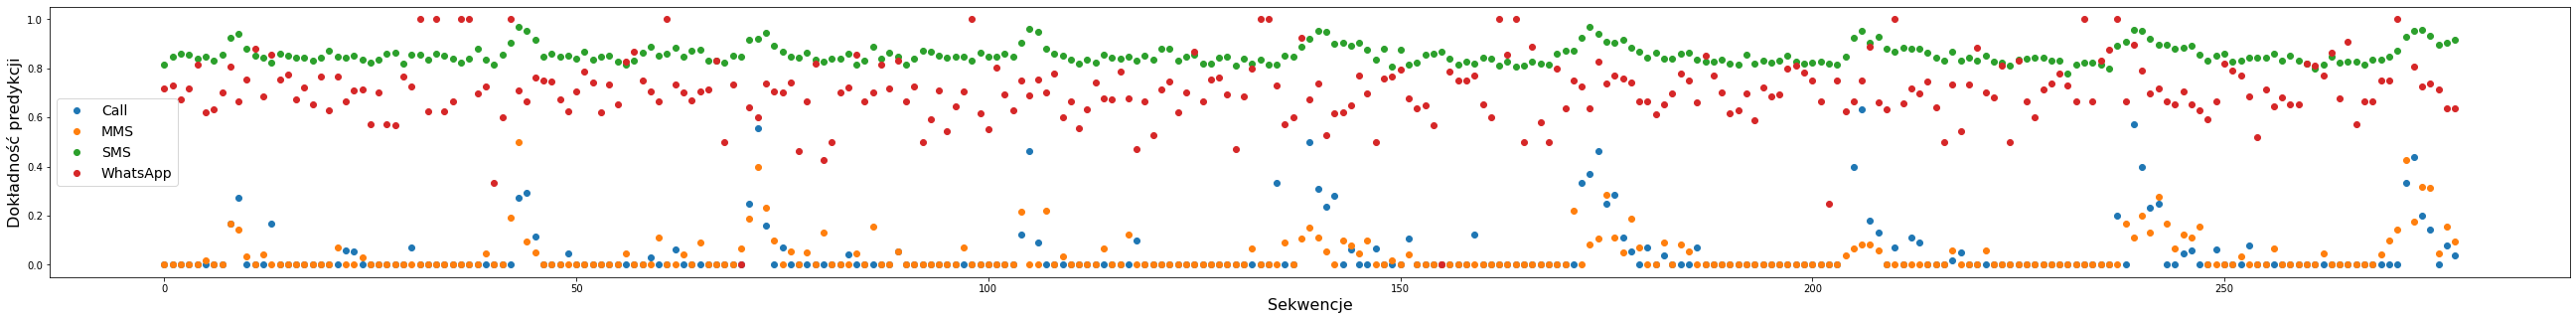

In [89]:
plotAccByType(acc_by_type)

In [90]:
acc_arr = acc_arr.numpy()
all_pred_times = all_pred_times.numpy()
events_predicted = events_predicted.numpy()

print("Średnia dokładność predykcji przyszłych rodzajów zdarzeń: {:.4f}%".format(np.mean(acc_arr)*100))

Średnia dokładność predykcji przyszłych rodzajów zdarzeń: 81.5197%


In [91]:
seq_avgs = np.zeros(n_test)
seq_log_avgs = np.zeros(n_test)

for seq in range(n_test):
    seq_len = len(test_events[seq])
    actual_time = test_times[seq, 1:seq_len]
    actual_time = [i if i != 0 else 1 for i in actual_time]
    predicted_time = all_pred_times[seq, 1:seq_len]
    dT2 = (predicted_time - actual_time)**2
    dT2_avg = np.sum(dT2)/seq_len
    seq_avgs[seq] = dT2_avg
    
print("Pierwiastek z uśrednionego błędu średniokwadratowego wartości czasu dla {} sekwencji testowych: {}".format(n_test, np.sqrt(np.mean(seq_avgs))))

Pierwiastek z uśrednionego błędu średniokwadratowego wartości czasu dla 279 sekwencji testowych: 3210.638361000539


In [96]:
def calcAccForAllEpoches():
    for epoch in range(n_epoch):
        try:
            net = torch.load("./social-interactions/{}/model_{}_{}_{}_{}_{}__{}.pt".format(dir, seq_len, database, batch_size, hidden_size, windows_p, epoch+1))

        except:
            print("No saved network found. Exit")
            return 

        net.to(cuda)

        all_pred_times = torch.ones(n_test, n_seq_max)*-1  # negative time means no event occurred
        acc_by_type = np.zeros((n_test,  n_types)) * -1
        acc_arr = torch.zeros(n_test)

        for idx in tqdm(range(n_test), position=0, leave=True):
          seq_len = len(test_events[idx])
          seq_events, seq_labels, times, embedded_events = getDetails(t_events, t_events_ids, t_times, idx, seq_len, t_embedded_events_test)
          times_predicted, events_predicted, correct_pred  = singleSeqThinningAlgorithm(net, seq_events, seq_labels, times, embedded_events)
          number_of_true_pred_types, number_of_types, acc_values_by_type = getAccByType(events_predicted, seq_labels)

          acc_by_type[idx] = acc_values_by_type
          acc_arr[idx] = torch.sum(correct_pred)/len(correct_pred)
          all_pred_times[idx, :seq_len] = times_predicted
        acc_arr = acc_arr.numpy()
        all_pred_times = all_pred_times.numpy()
        events_predicted = events_predicted.numpy()

        print("Średnia dokładność predykcji przyszłych rodzajów zdarzeń dla {}: {:.4f}%".format(epoch+1, np.mean(acc_arr)*100))
        
calcAccForAllEpoches()        

No saved network found. Starting from scratch
